In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from ast import literal_eval
import requests
import pickle
% matplotlib inline

### Load predicted safety dataset.

In [2]:
ss = pd.read_csv('data/streetscore_newyorkcity.csv')

In [3]:
ss.to_csv('data/ss_cartodb_pred.csv', index = False)

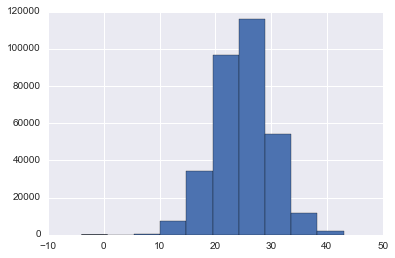

In [4]:
plt.hist(ss['q-score'])
plt.show()

### Load original dataset, which contains scores for safety, uniqueness, and upperclass.
* maximum q-score for each = 10; minimum q-score = 0

In [5]:
ss_orig = pd.read_json('data/streetscore_original.json')
ss_orig_nyc = ss_orig[ss_orig.City == 'New York City']

In [6]:
def to_float(data):
    try:
        return float(data)
    except:
        return np.nan

In [7]:
def df_to_float(df):
    cols = ['QS Safer', 'QS Unique', 'QS Upperclass', 'Error in QS Safer', 'Error in QS Unique', 'Error in QS Upperclass']
    for c in cols:
        df.loc[:, c] = df.loc[:, c].apply(to_float)

In [8]:
df_to_float(ss_orig_nyc)

//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


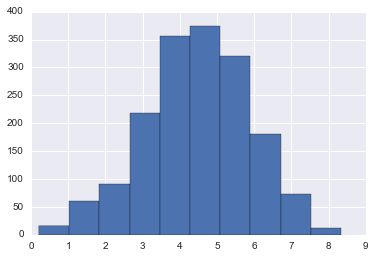

In [9]:
plt.hist(ss_orig_nyc['QS Safer'].dropna().values)
plt.show()

#### Export lat/long and ratings data to csv for CartoDB viz.

In [10]:
cdb = ss_orig_nyc.iloc[:, 7:]
cdb.drop('Pitch', axis = 1, inplace = True)

In [78]:
cdb.to_csv('data/ss_cartodb.csv', index = False)

### Add geographic labels to compare safety scores
1. zip code
2. neighborhood (based on Airbnb labels)
3. census block group

1. Get zip codes given latitude and longitude.

In [11]:
tlat = ss_orig_nyc.loc[2, 'Lat']
tlon = ss_orig_nyc.loc[2, 'Lon']

In [104]:
from geopy.geocoders import *

In [ ]:
def get_zip_master(lat, lon):
    loc = str(lat) + ', ' + str(lon)
    try:
        geolocator = Nominatim()
        location = geolocator.reverse(loc)
        return location.raw['address']['postcode']
    except:
        try:
            geolocator = ArcGIS()
            location = geolocator.reverse(loc)
            return location.raw['Postal']
        except:
            return 'no data'

In [109]:
# list of other geolocators to use: http://webgeodatavore.com/python-geocoders-clients-comparison.html
geolocator = ArcGIS()
    
def get_zip(lat, lon):
    """Return zip code given latitude and longitude point."""
    try:
        loc = str(lat) + ', ' + str(lon)
        location = geolocator.reverse(loc)
        return location.raw['Postal']
    except:
        try:
            time.sleep(1)
            loc = str(lat) + ', ' + str(lon)
            location = geolocator.reverse(loc)
            return location.raw['Postal']
        except:
            return 'no data'

In [110]:
def add_zips_df(df):
    df.loc[:, 'zipcode'] = df.apply(lambda row: get_zip(row.Lat, row.Lon), axis = 1)

In [111]:
%time add_zips_df(testdf)

CPU times: user 308 ms, sys: 26.6 ms, total: 334 ms
Wall time: 8.74 s


In [16]:
testdf = ss_orig_nyc.loc[:20]

In [27]:
ss_orig_nyc.dropna(inplace = True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [39]:
# apply to ss df
add_zips_df(ss_orig_nyc)

In [118]:
get_zip('40.7518', '-73.8613')

u'11368'

In [56]:
type(ss_orig_nyc.loc[4109, 'zipcode'])

float

In [60]:
ss_orig_nyc.zipcode.isnull().sum()

1184

In [107]:
b = ss_orig_nyc.fillna(value = 0)

In [119]:
yeszip = b[b.zipcode != 0]

In [113]:
nozip = b[b.zipcode == 0]

In [116]:
add_zips_df(nozip)

In [ ]:
nozip.loc[1226, :]

In [120]:
withzips = pd.concat([nozip, yeszip])

In [125]:
withzips[withzips.zipcode == 'no data'].shape

(68, 15)

3. Get census block group given lat & lon.

In [89]:
# use fcc API 
def get_cbg(lat, lon):
    try:
        url = 'http://data.fcc.gov/api/block/find'
        result = requests.get(url, params = {'latitude': lat, 
                                             'longitude': lon, 
                                             'format': 'json', 
                                             'showall': 'true'}).json()
        return result
    except: 
        return 'no data'

In [80]:
# use fcc API 
def get_cbg2(lat, lon):
    url = 'http://data.fcc.gov/api/block/find?format=json&latitude=%f&longitude=%f&showall=true' %(lat, lon)
#     url = 'http://data.fcc.gov/api/block/find'
    result = requests.get(url).json()
    return result

In [78]:
result = get_cbg(tlat, tlon)

In [128]:
def add_fips(df):
    df['fips'] = df.apply(lambda row: get_cbg(row.latitude, row.longitude), axis = 1)

In [90]:
add_fips(ss_orig_nyc)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [ ]:
add_fips(ss)

In [ ]:
2*2

In [92]:
ss_orig_nyc

City  Error in QS Safer  Error in QS Unique  \
2     New York City               0.58                0.80   
3     New York City               0.41                0.74   
4     New York City               0.58                0.70   
5     New York City               0.54                0.86   
6     New York City               0.61                0.82   
7     New York City               0.55                0.73   
8     New York City               0.60                0.77   
9     New York City               0.55                0.67   
10    New York City               0.58                0.70   
11    New York City               0.61                0.75   
13    New York City               0.46                0.83   
14    New York City               0.35                0.55   
15    New York City               0.46                0.67   
16    New York City               0.51                0.37   
17    New York City               0.57                0.52   
18    New York City               0.50                0.63   
19    New York City               0.52                0.85   
20    New York City               0.53                0.59   
21    New York City               0.50                0.61   
22    New York City               0.44                0.65   
23    New York City               0.57                0.82   
24    New York City               0.48                0.77   
25    New York City               0.50                0.71   
26    New York City               0.52                0.82   
27    New York City               0.55                0.67   
28    New York City               0.53                0.70   
51    New York City               0.51                0.57   
52    New York City               0.33                0.78   
53    New York City               0.51                0.81   
54    New York City               0.42                0.22   
...             ...                ...                 ...   
4045  New York City               0.35                0.77   
4047  New York City               0.54                0.65   
4048  New York City               0.50                0.60   
4050  New York City               0.34                0.63   
4051  New York City               0.49                0.69   
4059  New York City               0.51                0.60   
4067  New York City               0.62                0.66   
4068  New York City               0.44                0.75   
4069  New York City               0.57                0.76   
4070  New York City               0.49                0.73   
4071  New York City               0.57                0.72   
4072  New York City               0.53                0.57   
4073  New York City               0.53                0.73   
4075  New York City               0.44                0.58   
4081  New York City               0.58                0.20   
4082  New York City               0.28                0.53   
4083  New York City               0.53                0.69   
4084  New York City               0.48                0.65   
4085  New York City               0.44                0.53   
4086  New York City               0.48                0.75   
4087  New York City               0.36                0.82   
4089  New York City               0.48                0.72   
4090  New York City               0.46                0.53   
4103  New York City               0.40                0.67   
4106  New York City               0.33                0.54   
4109  New York City               0.45                0.72   
4115  New York City               0.41                0.56   
4123  New York City               0.30                0.78   
4132  New York City               0.41                0.68   
4135  New York City               0.50                0.84   

      Error in QS Upperclass                File_Location Heading    ID  \
2                       0.61  /images/id_4026_400_300.jpg       7  4026   
3                   

In [72]:
%time add_fips(testdf)

CPU times: user 99.6 ms, sys: 57 ms, total: 157 ms
Wall time: 12.5 s


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [127]:
ss

latitude  longitude    q-score
0       40.700909 -74.013504  11.062166
1       40.701000 -74.013878  10.818611
2       40.701080 -74.012878  12.677955
3       40.701187 -74.013268  11.417325
4       40.701244 -74.012115  25.199091
5       40.701332 -74.012573   9.335472
6       40.701401 -74.013954  21.422491
7       40.701462 -74.014297  11.072771
8       40.701477 -74.011406  21.323076
9       40.701496 -74.014694   9.223970
10      40.701530 -74.011810  17.142195
11      40.701630 -74.010490  18.004122
12      40.701633 -74.013344  11.630168
13      40.701645 -74.012650  19.722942
14      40.701756 -74.013657  21.745884
15      40.701801 -74.010841  31.937878
16      40.701805 -74.011185  12.101864
17      40.701832 -74.014389  33.230228
18      40.701839 -74.013031  20.000559
19      40.701866 -74.014786  10.209755
20      40.701874 -74.011955  31.014561
21      40.701900 -74.012337  28.533714
22      40.701923 -74.010117  21.787758
23      40.701931 -74.009720  19.279568
24      40.702129 -74.009071  19.291643
25      40.702164 -74.013741  20.415297
26      40.702179 -74.014130  23.511011
27      40.702187 -74.010666  28.589420
28      40.702194 -74.011383  26.885172
29      40.702206 -74.009476  23.618658
...           ...        ...        ...
322356  40.796204 -73.819260  27.857742
322357  40.796230 -73.821114  20.716995
322358  40.796230 -73.820320  27.039709
322359  40.796234 -73.821495  28.339390
322360  40.796238 -73.818893  30.401203
322361  40.796249 -73.819954  28.071350
322362  40.796417 -73.818512  21.956326
322363  40.796463 -73.819603  31.206936
322364  40.796471 -73.828392  22.468214
322365  40.796471 -73.828789  14.717350
322366  40.796505 -73.820503  24.613094
322367  40.796505 -73.820923  18.520164
322368  40.796513 -73.827629  23.938599
322369  40.796520 -73.822075  25.821342
322370  40.796532 -73.827263  21.659048
322371  40.796543 -73.823143  19.068476
322372  40.796558 -73.821709  28.213421
322373  40.796558 -73.826195  14.895672
322374  40.796558 -73.826553  17.902802
322375  40.796562 -73.822769  20.771002
322376  40.796734 -73.821327  21.998472
322377  40.796776 -73.822418  24.525810
322378  40.796818 -73.823318  22.717758
322379  40.796822 -73.823738  27.321709
322380  40.796822 -73.828926  14.613941
322381  40.796921 -73.826027  14.798035
322382  40.796940 -73.827057  19.615686
322383  40.796955 -73.826714  19.834711
322384  40.797199 -73.826363  15.853324
322385  40.797241 -73.827255  18.679102

[322386 rows x 3 columns]

In [ ]:
# pickle!
with open('data/ss_orig_nyc.pkl', 'w') as picklefile:
    pickle.dump(ss_orig_nyc, picklefile)
    

In [126]:
with open('data/ss_orig_withzips.pkl', 'w') as picklefile:
    pickle.dump(withzips, picklefile)

### Load crime data.

In [80]:
crime = pd.read_csv('data/NYPD_7_Major_Felony_Incidents.csv')

Add latitude and longitude columns.

In [127]:
def get_lat(x):
    """Get latitude given tuple pair of (latitude, longitude)."""
    try:
        return x.translate(None, "'(),").split()[0]
    except:
        return x
    
def get_long(x):
    """Get longitude given tuple pair of (latitude, longitude)."""
    try:
        return x.translate(None, "'(),").split()[1]
    except:
        return x

In [124]:
crime['lat'] = crime['Location 1'].apply(get_lat)
crime['long'] = crime['Location 1'].apply(get_long)

In [172]:
crime.head()

OBJECTID Identifier         Occurrence Date Day of Week  \
938452     938453   fde2a04e  07/04/2015 09:30:00 AM    Saturday   
1019901   1019902   8480f691  02/07/2015 02:40:00 AM    Saturday   
1019891   1019892    32f0496  02/07/2015 02:00:00 AM    Saturday   
1019892   1019893    3b3657c  02/07/2015 02:00:00 AM    Saturday   
1019893   1019894   5657e37f  02/07/2015 02:05:00 AM    Saturday   

        Occurrence Month  Occurrence Day  Occurrence Year  Occurrence Hour  \
938452               Jul               4             2015                9   
1019901              Feb               7             2015                2   
1019891              Feb               7             2015                2   
1019892              Feb               7             2015                2   
1019893              Feb               7             2015                2   

         CompStat Month  CompStat Day        ...          \
938452                7             4        ...           
1019901               2             7        ...           
1019891               2             8        ...           
1019892               2             7        ...           
1019893               2             7        ...           

         Offense Classification Sector Precinct    Borough      Jurisdiction  \
938452                   FELONY      D       48      BRONX  N.Y. POLICE DEPT   
1019901                  FELONY      N      113     QUEENS  N.Y. POLICE DEPT   
1019891                  FELONY      A       10  MANHATTAN  N.Y. POLICE DEPT   
1019892                  FELONY    NaN       13  MANHATTAN  N.Y. POLICE DEPT   
1019893                  FELONY      H       83   BROOKLYN  N.Y. POLICE DEPT   

        XCoordinate YCoordinate                             Location 1  \
938452      1014872      248381  (40.8483786620001, -73.8893182859999)   
1019901     1049817      193240          (40.696841261, -73.763548076)   
1019891      983690      209040          (40.740451337, -74.002022288)   
1019892      988874      207673           (40.73669807, -73.983316026)   
1019893     1008918      194147           (40.699539271, -73.91103807)   

                      lat               long  
938452   40.8483786620001  -73.8893182859999  
1019901      40.696841261      -73.763548076  
1019891      40.740451337      -74.002022288  
1019892       40.73669807      -73.983316026  
1019893      40.699539271       -73.91103807  

[5 rows x 22 columns]

Export relevant cols to csv for CartoDB visualization.

In [164]:
crime.sort_values(by = 'Occurrence Year', ascending = False, inplace = True)

In [176]:
crime_carto = crime.head(500000)

In [177]:
crime_carto = crime_carto[['Occurrence Date', 'Occurrence Year', 'Offense', 'lat', 'long']]

In [179]:
crime_carto.to_csv('data/felonies_cartodb_500k.csv', index = False)

In [ ]:
# interesting thing: plot date of actual occurence vs. date of reporting by type of crime

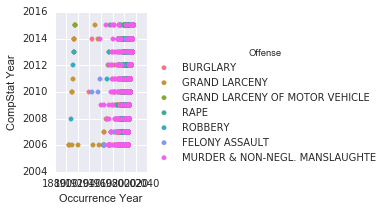

In [140]:
plt.figure(figsize = (10, 8))
fg = sns.FacetGrid(data=crime, hue='Offense')
fg.map(plt.scatter, 'Occurrence Year', 'CompStat Year').add_legend()

In [144]:
crime.Offense.value_counts().index.tolist()

['GRAND LARCENY',
 'ROBBERY',
 'BURGLARY',
 'FELONY ASSAULT',
 'GRAND LARCENY OF MOTOR VEHICLE',
 'RAPE',
 'MURDER & NON-NEGL. MANSLAUGHTE']

In [145]:
colors = ['blue', 'black', 'purple', 'orange', 'green', 'red', 'pink']

In [146]:
colormap = dict(zip(crime.Offense.value_counts().index.tolist(), colors))

In [153]:
colormap[np.nan] = 'white'

In [154]:
colors_list = map(lambda x: colormap[x], crime.Offense.tolist())

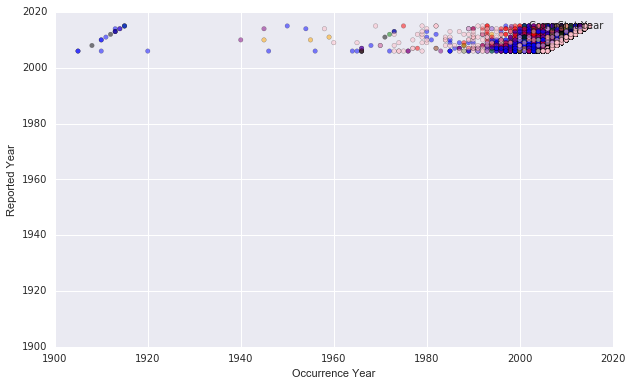

In [157]:
plt.figure(figsize = (10, 6))
plt.scatter(crime['Occurrence Year'], crime['CompStat Year'], alpha = 0.5, c = colors_list)
plt.xlabel('Occurrence Year')
plt.xlim(1900, 2020)
plt.ylim(1900, 2020)
plt.ylabel('Reported Year')
plt.legend(loc = 'best')
plt.show()

### Investigate Airbnb data

In [184]:
reviews = pd.read_csv('data/airbnb_reviews.csv')

In [185]:
reviews.head()

listing_id        id        date  reviewer_id reviewer_name  \
0     6987560  36646383  2015-06-29     36898998       Matthew   
1     6987560  50598904  2015-10-12     45823035          Ines   
2     7652181  43187122  2015-08-17     24166824          Alex   
3     7652181  51978920  2015-10-25      5528953         Heath   
4     7652181  52545546  2015-10-30     21292281         Ryanm   

                                            comments  
0  The host canceled this reservation 6 days befo...  
1  This was my first Airbnb experience so I was a...  
2  Felix was really a great host. The apartment i...  
3  Felix was a great host, I would happily stay h...  
4  Felix is a gracious host, and the apartment is...

In [180]:
airbnb = pd.read_csv('data/airbnb_reviews_identifiers.csv')

In [181]:
airbnb.head()

listing_id        date
0     6987560  2015-06-29
1     6987560  2015-10-12
2     7652181  2015-08-17
3     7652181  2015-10-25
4     7652181  2015-10-30

In [182]:
a = pd.read_csv('data/airbnb_listings.csv')

In [183]:
a.head()

id                                 name   host_id       host_name  \
0  6627449       Large 1 BDRM in Great location  13886510          Arlene   
1  7949480  City Island Sanctuary Sunny BR & BA    119445  Linda & Didier   
2  1886820       Quaint City Island Community.    9815788           Steve   
3  5557381              Quaint City Island Home  28811542          Phoebe   
4  9019702              City Island Sugar Shack  46642112            Jody   

  neighbourhood_group neighbourhood   latitude  longitude        room_type  \
0               Bronx   City Island  40.849775 -73.786609  Entire home/apt   
1               Bronx   City Island  40.852054 -73.788680     Private room   
2               Bronx   City Island  40.841144 -73.783052  Entire home/apt   
3               Bronx   City Island  40.850024 -73.789328     Private room   
4               Bronx   City Island  40.847917 -73.787731  Entire home/apt   

   price  minimum_nights  number_of_reviews last_review  reviews_per_month  \
0    125               3                  8  2016-01-05               1.12   
1     68               1                  1  2016-01-18               1.00   
2    300               7                  0         NaN                NaN   
3     49               1                 41  2016-01-29               4.84   
4    200               1                  0         NaN                NaN   

   calculated_host_listings_count  availability_365  
0                               1               337  
1                               1               349  
2                               1               365  
3                               1               344  
4                               1               365

In [186]:
a2 = pd.read_csv('data/airbnb_neighbourhoods.csv')